## **Getting started**

**Business Objective:**

“Will a customer accept the coupon?” The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those who did not.

**Problem Statement:** Determine which features are most strongly associated with coupon acceptance and provide actionable insights.


**Proposed Process Resolution:**
This notebook analyzes the factors influencing coupon acceptance (Y=1) versus non-acceptance (Y=0):
Coupon Acceptance/Rejection Fetures Discovery/Analysis/Correlation. Including data clensing, correlation analysis, and visualizations that compares key features.


**Findings:**
  **Age** and certain time thresholds (e.g., **toCoupon_GEQ15min** and **toCoupon_GEQ25min**) are strong predictors of coupon acceptance.
  **Some features, like **temperature**, are more related to coupon rejection.



In [70]:
# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import datetime as dt

import os
from google.colab import files

from scipy.stats import chi2_contingency



# for UCB 5.1 Coupan db cleanup, exploration, analysis, feature engineering

# Data Cleaning & Preparation

## Steps:
### 1. Remove rows with missing values in key columns.
### 2. Drop duplicate rows.
### 3. Convert specific columns to numeric.
### 4. Split the dataset into coupon accepted (Y=1) and not accepted (Y=0).
### 5. Cap outliers at the 1st and 99th percentiles.
### 6. Measure strongest correlation
### 7. Check Violin charts to confirm

#  Correlation Analysis
## Coupon Acceptance Analysis

## The top three features correlated with coupon acceptance are:
### - **age**
### - **occupation_Legal**
### - **car_crossover**


# least correlated: direction_same

# Recommendation:
## Target by Age as it is  most correlated with coupon acceptance.


In [2]:
#file list
files = os.listdir('/content/')
print(files)

['.config', 'sample_data']


In [3]:
# upload data csv files, uncomment
from google.colab import files
uploaded = files.upload()

Saving coupons.csv to coupons.csv


In [206]:
#load uploaded csv file
cpn = pd.read_csv('/content/coupons.csv')
# print(cpn.count())

In [207]:
# Explore data
# cpn.head()
# cpn.describe()
# cpn.info()
cpn.isna().sum()



,0
destination,0
passanger,0
weather,0
temperature,0
time,0
coupon,0
expiration,0
gender,0
age,0
maritalStatus,0


In [208]:

# One-hot encode categorical columns. "maritalstatus" not an index
categorical_cols = [
    "destination", "passanger", "weather", "coupon", "expiration",
    "gender", "education", "occupation", "car"
]
cpn = pd.get_dummies(cpn, columns=categorical_cols, drop_first=True)
cpn.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [209]:
# Lower Case Col Names
cpn.columns = cpn.columns.str.lower()
cpn.columns

Index(['temperature', 'time', 'age', 'maritalstatus', 'has_children', 'income',
       'bar', 'coffeehouse', 'carryaway', 'restaurantlessthan20',
       'restaurant20to50', 'tocoupon_geq5min', 'tocoupon_geq15min',
       'tocoupon_geq25min', 'direction_same', 'direction_opp', 'y',
       'destination_no urgent place', 'destination_work',
       'passanger_friend(s)', 'passanger_kid(s)', 'passanger_partner',
       'weather_snowy', 'weather_sunny', 'coupon_carry out & take away',
       'coupon_coffee house', 'coupon_restaurant(20-50)',
       'coupon_restaurant(<20)', 'expiration_2h', 'gender_male',
       'education_bachelors degree',
       'education_graduate degree (masters or doctorate)',
       'education_high school graduate', 'education_some high school',
       'education_some college - no degree',
       'occupation_arts design entertainment sports & media',
       'occupation_building & grounds cleaning & maintenance',
       'occupation_business & financial',
       'occupa

In [210]:
# loop for all col unuques. destination',
key_columns = cpn.columns

for colname in key_columns:
  print(colname)
  print( cpn[colname].unique() )

temperature
[55 80 30]
time
['2PM' '10AM' '6PM' '7AM' '10PM']
age
['21' '46' '26' '31' '41' '50plus' '36' 'below21']
maritalstatus
['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']
has_children
[1 0]
income
['$37500 - $49999' '$62500 - $74999' '$12500 - $24999' '$75000 - $87499'
 '$50000 - $62499' '$25000 - $37499' '$100000 or More' '$87500 - $99999'
 'Less than $12500']
bar
['never' 'less1' '1~3' 'gt8' nan '4~8']
coffeehouse
['never' 'less1' '4~8' '1~3' 'gt8' nan]
carryaway
[nan '4~8' '1~3' 'gt8' 'less1' 'never']
restaurantlessthan20
['4~8' '1~3' 'less1' 'gt8' nan 'never']
restaurant20to50
['1~3' 'less1' 'never' 'gt8' '4~8' nan]
tocoupon_geq5min
[1]
tocoupon_geq15min
[0 1]
tocoupon_geq25min
[0 1]
direction_same
[0 1]
direction_opp
[1 0]
y
[1 0]
destination_no urgent place
[ True False]
destination_work
[False  True]
passanger_friend(s)
[False  True]
passanger_kid(s)
[False  True]
passanger_partner
[False  True]
weather_snowy
[False  True]
weather_sunny
[ True False

In [211]:
# DUPLICATES
# drop nulls, blanks..., dedup, reset index
# cpn = cpn.dropna(how="any").reset_index(drop=True)

cpnduplicates = cpn.duplicated(subset = key_columns, keep = False)
print("Total rows before drop_duplicates:", len(cpn))
print("Total exact duplicates:", cpn.duplicated().sum())

# Drop duplicates
cpn = cpn.dropna(subset=key_columns).drop_duplicates().reset_index(drop=True).copy()
# confirm nulls, blanks.. removed
# cpn.isna().sum()
# print( "cpn count" )
# print( cpn.count() )


# print(cpn[cpn.duplicated(subset=key_columns, keep=False)])

cpnduplicatescheck = cpn.duplicated(subset = key_columns, keep = False)
print("Total rows before drop_duplicates:", len(cpn))
print("Total exact duplicates:", cpn.duplicated().sum())

Total rows before drop_duplicates: 12684
Total exact duplicates: 74
Total rows before drop_duplicates: 12007
Total exact duplicates: 0


In [212]:
# Problem: income has $ signs
# Clean: strip dollar sign from income, convert to float


cpn['income'].unique()
# Function to convert income ranges to float
def convert_income_to_float(income_str):
    try:
        if "or More" in income_str:
            return float(income_str.split()[0])  # Extract number before "or More"
        else:
            lower, upper = map(int, income_str.replace("$", "").split(" - "))
            return (lower + upper) / 2  # Compute the midpoint
    except (ValueError, TypeError):
        return float("nan")  # Coerce invalid values to NaN

# Apply transformation
cpn["income"] = cpn["income"].apply(convert_income_to_float)

cpn['income'] = cpn['income'].astype("float")

In [213]:
# Problem: Age has text like plus...
# Fix:  cleanup, standardize
def clean_age(age):
    """Convert age strings to integer or standardized categories."""
    age = age.strip().lower()  # Trim spaces and make lowercase

    if age == "50plus":
        return 50  # Represent as 50
    elif age == "below21":
        return 20  # Represent as 20 (alternative: use 18)
    elif age.isdigit():
        return int(age)  # Convert valid numbers
    else:
        return None  # Handle unexpected values

# Apply cleaning function to 'age' column **in-place**
cpn["age"] = cpn["age"].apply(clean_age)


# print(df)# Cleanse: Data transformation to numeric where possible
# Convert Age to integer
print(cpn["age"].unique())

[21 46 26 31 41 50 36 20]


In [214]:

# # Convert ordinal categorical values to numerical
ordinal_mapping = {
    "never": 0,
    "less1": 0.5,
    "1~3": 2,
    "4~8": 6,
    "gt8": 9
}
cpn["bar"] = cpn["bar"].map(ordinal_mapping)
cpn["coffeehouse"] = cpn["coffeehouse"].map(ordinal_mapping)
cpn["carryaway"] = cpn["carryaway"].map(ordinal_mapping)
cpn["restaurantlessthan20"] = cpn["restaurantlessthan20"].map(ordinal_mapping)
cpn["restaurant20to50"] = cpn["restaurant20to50"].map(ordinal_mapping)


# Convert time to 24-hour format
time_map = {
    "7AM": 7, "10AM": 10, "2PM": 14, "6PM": 18, "10PM": 22
}
cpn["time"] = cpn["time"].map(time_map)


binary_cols = [
    "has_children", "tocoupon_geq5min", "tocoupon_geq15min",
    "tocoupon_geq25min", "direction_same", "direction_opp", "y"
]

cpn[binary_cols] = cpn[binary_cols].astype(int)

cpn = cpn.dropna().reset_index(drop=True)
cpn.isna().sum()


,0
temperature,0
time,0
age,0
maritalstatus,0
has_children,0
...,...
occupation_unemployed,0
car_mazda5,0
car_scooter and motorcycle,0
car_crossover,0


In [199]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# cpn[["age", "income", "temperature"]] = scaler.fit_transform(cpn[["age", "income", "temperature"]])


In [200]:
# split datasets for yes/no coupon acceptance and rejection


# Split data based on coupon acceptance or not
cpnYes = cpn[cpn['y'] == 1].copy()
cpnNo  = cpn[cpn['y'] == 0].copy()

print("cpn yes count")
# print( cpnYes.count() ) # 62, > 32 for statistical sample needed
print("------------------------------------------")

print("cpn no count")
# print( cpnNo.count() ) # 46, > 32 for statistical sample needed
print("------------------------------------------")
# cpn.dtypes

cpn yes count
------------------------------------------
cpn no count
------------------------------------------


In [216]:

# OUTLIERS Quantile CLEANUP for yes and no coupon dataset split
## Cap outliers for each numeric column in both groups (1st to 99th percentiles) 'gender',
numeric_cols = [
    'temperature', 'time', 'age', 'income', 'bar', 'coffeehouse', 'carryaway',
    'restaurantlessthan20', 'restaurant20to50', 'has_children',
    'tocoupon_geq5min', 'tocoupon_geq15min', 'tocoupon_geq25min',
    'direction_same', 'direction_opp', 'y'
]



for col in numeric_cols:
  lower_cap_yes = cpn[col].quantile(0.01)
  upper_cap_yes = cpn[col].quantile(0.99)
  cpn[col] = cpn[col].clip(lower_cap_yes, upper_cap_yes)

  lower_cap_yes = cpnYes[col].quantile(0.01)
  upper_cap_yes = cpnYes[col].quantile(0.99)
  cpnYes[col] = cpnYes[col].clip(lower_cap_yes, upper_cap_yes)

  lower_cap_no = cpnNo[col].quantile(0.01)
  upper_cap_no = cpnNo[col].quantile(0.99)
  cpnNo[col] = cpnNo[col].clip(lower_cap_no, upper_cap_no)

#save clean data file
cpn.to_csv('1_coupon_csv-clean-YES-AND-NO.csv', index=False)
cpnYes.to_csv('2_coupon_csv-clean-accept-yes.csv', index=False)
cpnNo.to_csv('3_coupon_csv-clean-accept-no.csv', index=False)


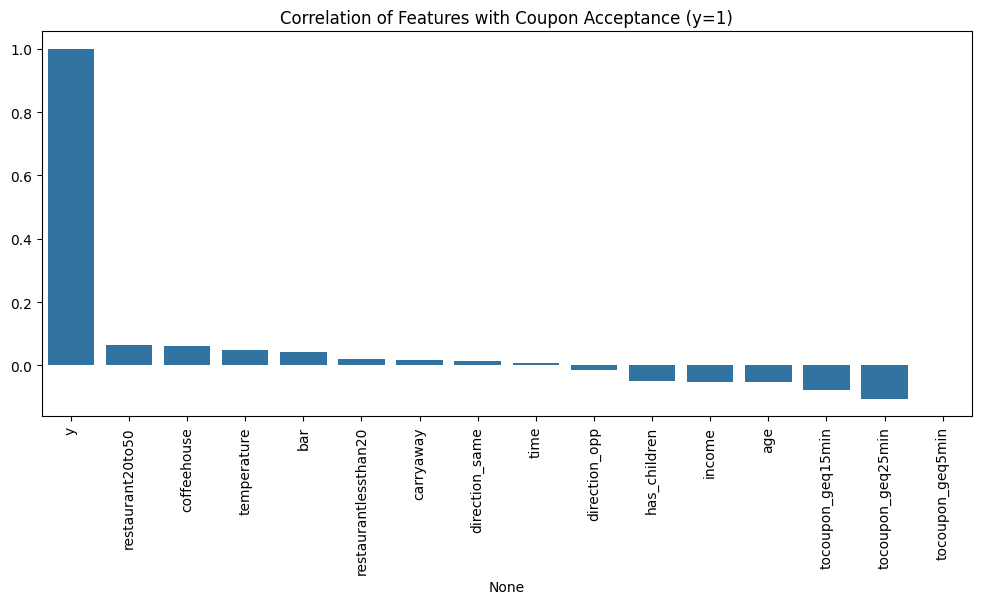

------------------------------------------
Overall Correlation with Y=1 Acceptance
y                       1.000000
restaurant20to50        0.063217
coffeehouse             0.060666
temperature             0.049735
bar                     0.043411
restaurantlessthan20    0.019977
carryaway               0.016710
direction_same          0.013755
time                    0.008123
direction_opp          -0.013755
has_children           -0.049349
income                 -0.051863
age                    -0.052574
tocoupon_geq15min      -0.077882
tocoupon_geq25min      -0.105798
tocoupon_geq5min             NaN
Name: y, dtype: float64
------------------------------------------

Features sorted by absolute correlation with Y:
tocoupon_geq25min       0.105798
tocoupon_geq15min       0.077882
restaurant20to50        0.063217
coffeehouse             0.060666
age                     0.052574
income                  0.051863
temperature             0.049735
has_children            0.049349
bar      

In [202]:

#  CORRELATION ANALYSIS
# Corr matrix numeric: ID features strongly associated with coupon acceptance.
# Features with high positive correlation are more prevalent in the coupon accepted group.
# Compute overall correlation matrix

# Select only numeric columns from cpn
cpn_numeric = cpn.select_dtypes(include=['number'])  # Exclude non-numeric columns

# Compute correlation matrix on numeric data
corr_matrix = cpn_numeric.corr()

# Compute correlation with y
if "y" in corr_matrix.columns:  # Ensure y exists
    correlation_with_y = corr_matrix["y"].sort_values(ascending=False)

    # Visualizing correlation
    plt.figure(figsize=(12, 5))
    sns.barplot(x=correlation_with_y.index, y=correlation_with_y.values)
    plt.xticks(rotation=90)
    plt.title("Correlation of Features with Coupon Acceptance (y=1)")

    # Save the figure before displaying
    plot_filename = "4_correlation_coupon_acceptance.png"
    plt.savefig(plot_filename, bbox_inches='tight')

    # Show the plot after saving
    plt.show()

    print("------------------------------------------")
    print("Overall Correlation with Y=1 Acceptance")
    print(correlation_with_y)
    print("------------------------------------------")

    # Identify top features by absolute correlation with Y (excluding Y itself)
    corr_features = correlation_with_y.drop('y').abs().sort_values(ascending=False)
    print("\nFeatures sorted by absolute correlation with Y:")
    print(corr_features)
    print("------------------------------------------")

    nocorr_features = correlation_with_y.drop('y').abs().sort_values(ascending=True)
    print("\nFeatures sorted by Least correlation with Y:")
    print(nocorr_features)
    print("------------------------------------------")

    top3_accept = corr_features.head(8)
    print("\nTop 8 features most correlated with coupon not accepted (Y=1):")
    print(top3_accept)


    top3_reject = nocorr_features.head(8)
    print("\nTop 8 features Least correlated with coupon not accepted (Y=0):")
    print(top3_reject)




In [146]:
# print( cpnYes.columns)

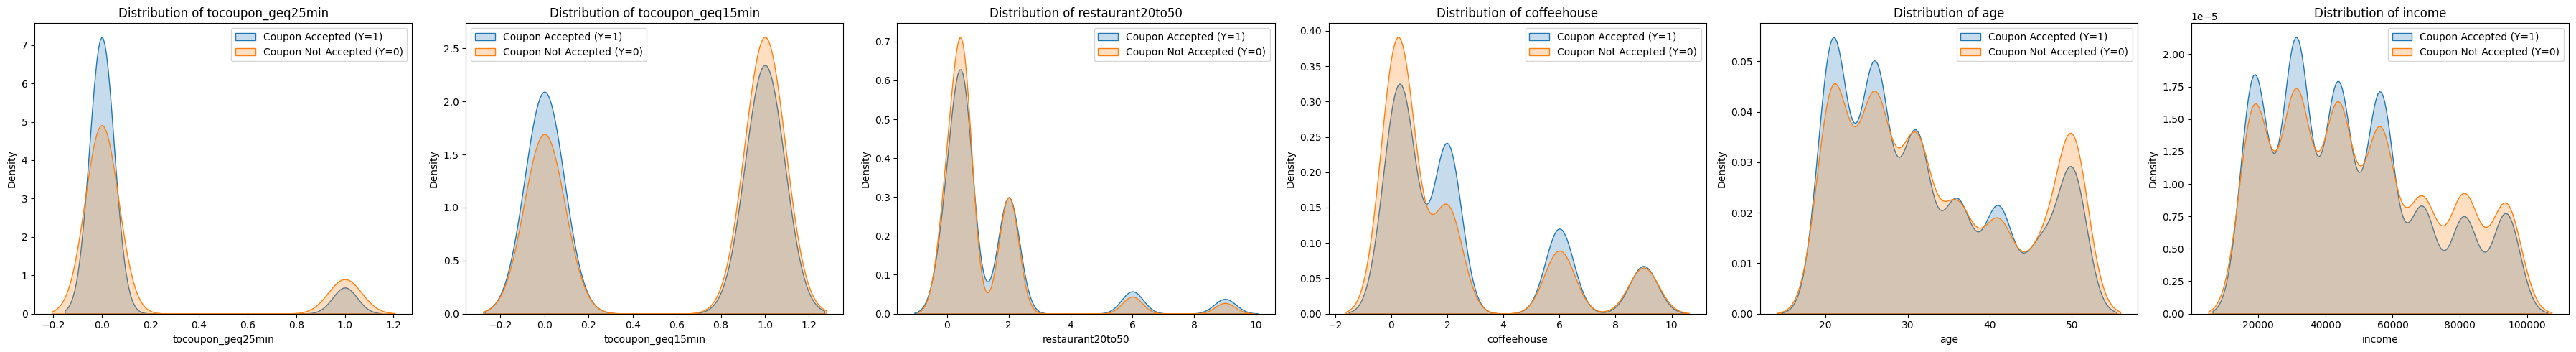

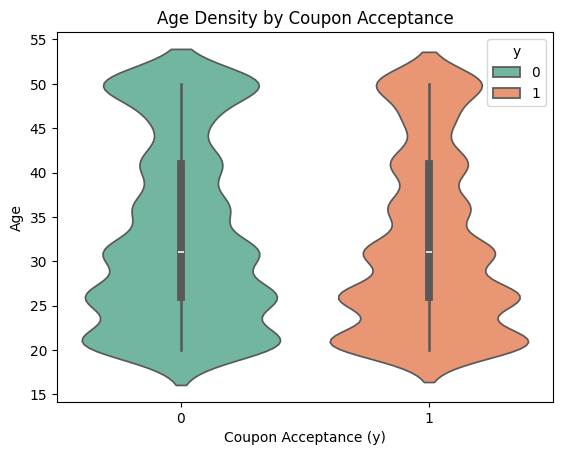

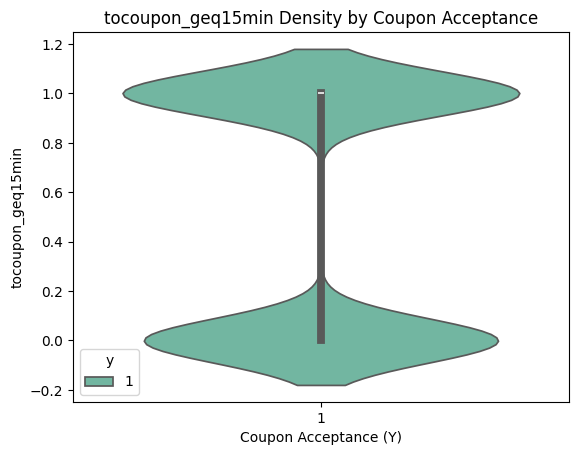

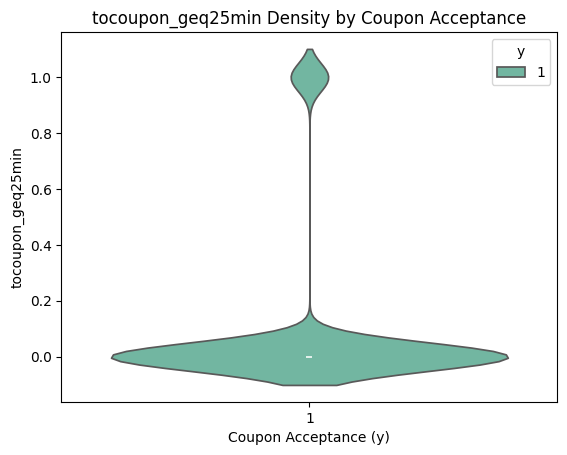

In [203]:

# TOP FEATURES supporting coupon acceptance
# Charts: KDE, Violin, for
# see: KDE & Violin Plots of distribution for these features ( both coupon acceptance/rejection ).

# print( cpnYes.columns)


features_to_plot = top3_accept


# Ensure the correct column names are used in features_to_plot
features_to_plot = top3_accept

features_most_correlated_to_plot = [
    'tocoupon_geq25min',  # Strongest negative correlation
    'tocoupon_geq15min',  # Second strongest negative correlation
    'restaurant20to50',   # Strongest positive correlation
    'coffeehouse',        # Second strongest positive correlation
    'age',                # Moderate negative correlation
    'income'              # Moderate negative correlation
]


# Increase figure width for better readability
plt.figure(figsize=(len(features_most_correlated_to_plot) * 6, 5))  # Increased width per feature

# KDE plots for each feature in features_to_plot
for i, feature in enumerate(features_most_correlated_to_plot):
    plt.subplot(1, len(features_most_correlated_to_plot), i + 1)
    sns.kdeplot(data=cpnYes, x=feature, label='Coupon Accepted (Y=1)', fill=True)
    sns.kdeplot(data=cpnNo, x=feature, label='Coupon Not Accepted (Y=0)', fill=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig("./4_top_features_accepting_coupon.png")  # Save with adjusted width
plt.show()



# Violin plot confirms age correlation to coupon
sns.violinplot(x='y', y='age', data=cpn, hue='y', palette='Set2', legend=True)
plt.title("Age Density by Coupon Acceptance")
plt.xlabel("Coupon Acceptance (y)")
plt.ylabel("Age")
plt.savefig("./5_top_features_age_accepting_coupon.png")  # Save with adjusted width
plt.show()

# Violin plot confirms toCoupon_GEQ15min correlation to coupon
sns.violinplot(
    x='y',
    y='tocoupon_geq15min',  # Ensure column matches the correct case
    data=cpnYes,
    hue='y',
    palette='Set2'
)
plt.title("tocoupon_geq15min Density by Coupon Acceptance")
plt.xlabel("Coupon Acceptance (Y)")
plt.ylabel("tocoupon_geq15min")
plt.savefig("./6_top_features_tocoupon_geq15min_accepting_coupon.png")  # Save with adjusted width
plt.show()


# Violin plot confirms toCoupon_GEQ25min correlation to coupon
# Convert column names to lowercase
sns.violinplot(
    x='y',  # Ensure lowercase
    y='tocoupon_geq25min',  # Ensure lowercase
    data=cpnYes,
    hue='y',
    palette='Set2'
)

plt.title("tocoupon_geq25min Density by Coupon Acceptance")
plt.xlabel("Coupon Acceptance (y)")
plt.ylabel("tocoupon_geq25min")
plt.savefig("./7_top_features_tocoupon_geq25min_accepting_coupon.png")  # Save with adjusted width
plt.show()



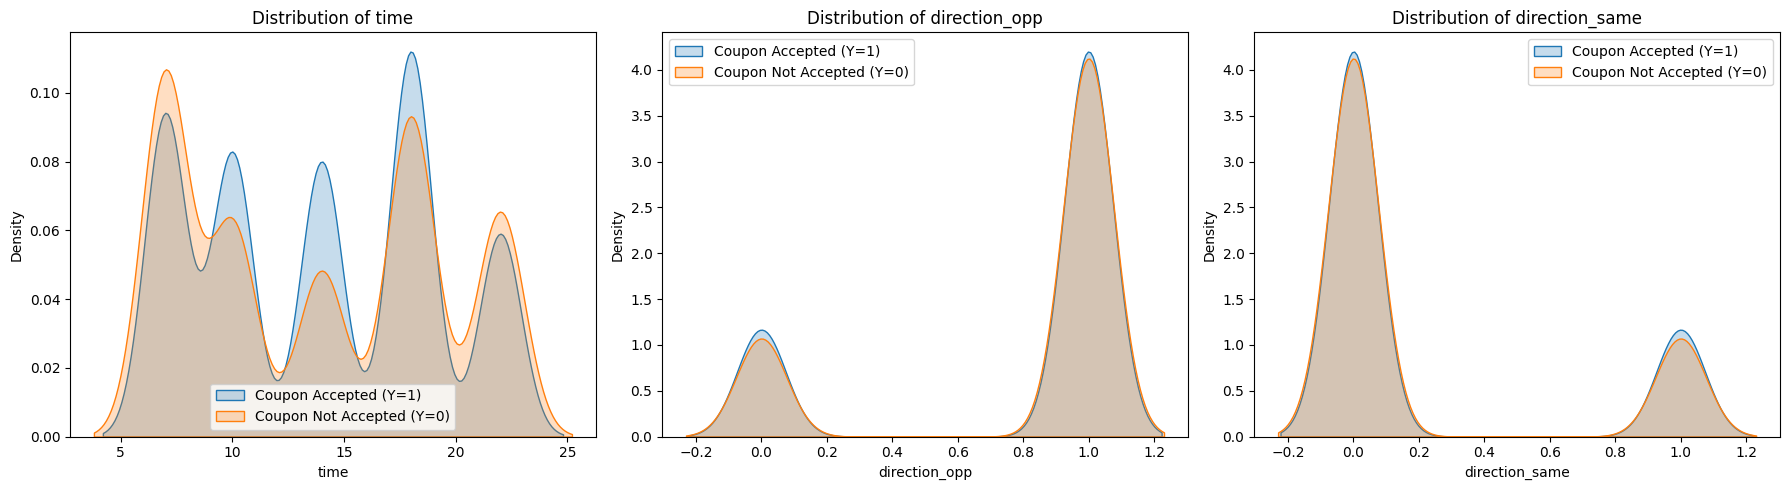

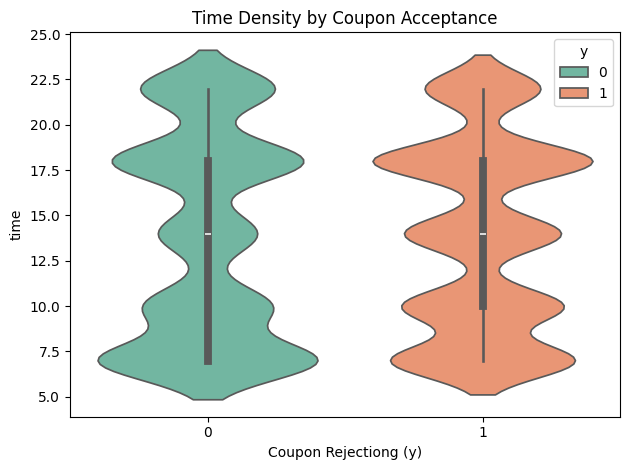

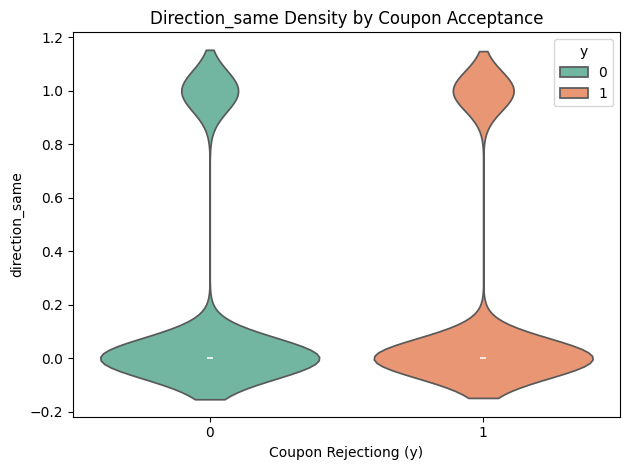

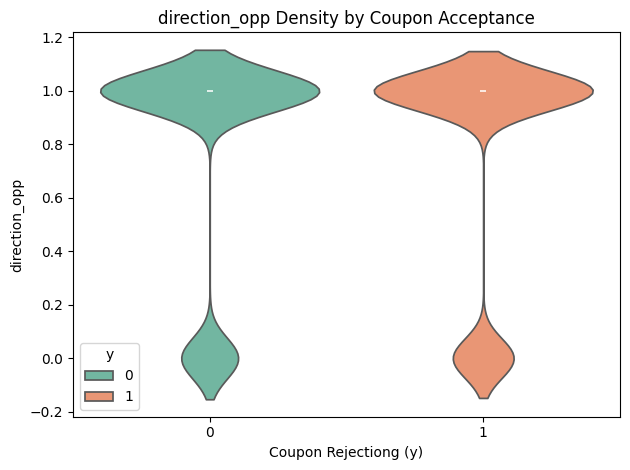

In [204]:
# TOP FEATURES supporting coupon Rejectiong
# Charts: KDE, Violin, for
# see: KDE & Violin Plots of distribution for these features ( both coupon acceptance/rejection ).

# print( cpnYes.columns)


features_to_plot = top3_accept


# Ensure the correct column names are used in features_to_plot
features_to_plot = top3_reject

features_least_correlated_to_plot = [
    'time',  # Strongest negative correlation
    'direction_opp',  # Second strongest negative correlation
    'direction_same',   # Strongest positive correlation

]



# Increase figure width for better readability
plt.figure(figsize=(len(features_least_correlated_to_plot) * 6, 5))  # Increased width per feature

# KDE plots for each feature in features_to_plot
for i, feature in enumerate(features_least_correlated_to_plot):
    plt.subplot(1, len(features_least_correlated_to_plot), i + 1)
    sns.kdeplot(data=cpnYes, x=feature, label='Coupon Accepted (Y=1)', fill=True)
    sns.kdeplot(data=cpnNo, x=feature, label='Coupon Not Accepted (Y=0)', fill=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig("./8_top_features_rejecting_coupon.png")  # Save with adjusted width
plt.show()



# Violin plot confirms time correlation to coupon
sns.violinplot(x='y', y='time', data=cpn, hue='y', palette='Set2', legend=True)
plt.title("Time Density by Coupon Acceptance")
plt.xlabel("Coupon Rejectiong (y)")
plt.ylabel("time")
plt.tight_layout()
plt.savefig("./9_Violin_time_rejecting_coupon.png")  # Save with adjusted width
plt.show()

# Violin plot confirms direction_same correlation to coupon
sns.violinplot(x='y', y='direction_same', data=cpn, hue='y', palette='Set2', legend=True)
plt.title("Direction_same Density by Coupon Acceptance")
plt.xlabel("Coupon Rejectiong (y)")
plt.ylabel("direction_same")
plt.tight_layout()
plt.savefig("./10_Violin_direction_same_rejecting_coupon.png")  # Save with adjusted width
plt.show()


# Violin plot confirms direction_opp correlation to coupon
sns.violinplot(x='y', y='direction_opp', data=cpn, hue='y', palette='Set2', legend=True)
plt.title("direction_opp Density by Coupon Acceptance")
plt.xlabel("Coupon Rejectiong (y)")
plt.ylabel("direction_opp")
plt.tight_layout()
plt.savefig("./11_Violin_tdirection_opp_rejecting_coupon.png")  # Save with adjusted width
plt.show()






#DBL check corr matrix# Compute the correlation matrix

# yescorr_matrix = cpnYes.corr()

# Assume 'Y' is your coupon acceptance column (with 1 indicating acceptance)
# Get correlations of all features with Y, excluding Y itself
# target_corr = yescorr_matrix['Y'].drop('Y')

# Find the feature with the highest absolute correlation with Y
# most_corr_feature = target_corr.abs().idxmax()
# yescorrelation_value = target_corr[most_corr_feature]
# yescorrelation_value


#nocorr_matrix = cpnNo.corr()
# Assume 'Y' is your coupon rejection column (with 0 indicating rejection)
# Get correlations of all features with Y, excluding Y itself
# target_corr = nocorr_matrix['Y'].drop('Y')

# Find the feature with the highest absolute correlation with Y
# most_corr_feature = target_corr.abs().idxmax()
# nocorrelation_value = target_corr[most_corr_feature]
# nocorrelation_value


# ## Coupon Non-Acceptance Analysis
#
# Features with negative correlations (i.e., more associated with coupon non-acceptance).
#  visualize top three features associated with coupon rejection.



# plt.figure(figsize=(18, 5))
# for i, feature in enumerate(features_to_plot_not_accept):
#     plt.subplot(1, 3, i+1)
#     sns.kdeplot(data=cpnYes, x=feature, label='Coupon Accepted (y=1)', fill=True)
#     sns.kdeplot(data=cpnNo,  x=feature, label='Coupon Not Accepted (y=0)', fill=True)
#     plt.title(f"Distribution of {feature}")
#     plt.xlabel(feature)
#     plt.ylabel('Density')
#     plt.legend()
# plt.tight_layout()


#  Save the figure before displaying
# plot_filename = "5_top3_features_not_accepting_coupon.png"
# plt.savefig(plot_filename, bbox_inches='tight')

# Show the plot after saving
# plt.show()


# ## Additional Feature Exploration
#
# Histograms are plotted for each numeric feature for both coupon accepted and non-accepted groups.
# This helps to further understand the distribution differences.


# fig, axes = plt.subplots(nrows=2, ncols=len(numeric_cols), figsize=(16, 8))
# for i, col in enumerate(numeric_cols):
#     sns.histplot(cpnYes[col], ax=axes[0, i], kde=True, color='green')
#     axes[0, i].set_title(f"{col} (y=1)")
#     sns.histplot(cpnNo[col], ax=axes[1, i], kde=True, color='red')
#     axes[1, i].set_title(f"{col} (y=0)")
# plt.tight_layout()
# plt.show()

# ## Categorical Variable Analysis
#
# explore categorical variables and their relation to coupon acceptance using count plots.

# cat_cols = ['car_Mazda5', 'car_crossover',    'coffeehouse', 'carryaway',]
# for col in cat_cols:
#     sns.countplot(x=col, hue='y', data=cpnYes)
#     plt.title(f"{col} vs. Coupon Acceptance (y)")
#     plt.xlabel(col)
#     plt.ylabel("Count")
#     plt.legend(title='Coupon Status', labels=['Not Accepted (Y=0)', 'Accepted (Y=1)'])
#     plt.show()


#     sns.countplot(x=col, hue='y', data=cpnNo)
#     plt.title(f"{col} vs. Coupon Acceptance (y)")
#     plt.xlabel(col)
#     plt.ylabel("Count")
#     plt.legend(title='Coupon Status', labels=['Not Accepted (Y=0)', 'Accepted (Y=1)'])
#     plt.show()



In [205]:
# Define categorical columns
categorical_cols = [
    "destination_Home", "passanger", "weather", "coupon", "expiration",
    "gender", "maritalstatus", "education", "occupation", "car"
]

# Keep only columns that exist in the dataset
existing_categorical_cols = [col for col in categorical_cols if col in cpn.columns]

# Perform Chi-Square test for each categorical column
chi_square_results = {}

for col in existing_categorical_cols:
    contingency_table = pd.crosstab(cpn[col], cpn["y"])  # Create contingency table
    chi2, p, dof, expected = chi2_contingency(contingency_table)  # Chi-Square test

    chi_square_results[col] = p  # Store p-value
    print(f"{col}: p-value = {p:.4f}")

# Sort results by significance (smallest p-values first)
sorted_results = sorted(chi_square_results.items(), key=lambda x: x[1])

# Display sor


maritalstatus: p-value = 0.0000
